In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [3]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [5]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [6]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [7]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [8]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
def build_1d_cnn_custom_BN(conv_num=1):
    init_channel = 256
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/3))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(BatchNormalization())
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [10]:
for i in range(1, 10):
    model = build_1d_cnn_custom_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 256)        1024      
_________________________________________________________________
activation (Activation)      (None, 16000, 256)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096000)           0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 4096000)           16384000  
_________________________________________________________________
dense (Dense)                (None, 16)                65536016  
Total params: 81,922,576
Trainable params: 73,730,064
Non-trainable pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 256)         0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_44 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 256)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8993 - acc: 0.4995
Epoch 00001: val_loss improved from inf to 1.60971, saving model to model/checkpoint/1D_CNN_custom_4_BN_4_conv_checkpoint/001-1.6097.hdf5
36805/36805 [==============================] - 414s 11ms/sample - loss: 1.8993 - acc: 0.4995 - val_loss: 1.6097 - val_acc: 0.5148
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1407 - acc: 0.6917
Epoch 00002: val_loss did not improve from 1.60971
36805/36805 [==============================] - 409s 11ms/sample - loss: 1.1409 - acc: 0.6916 - val_loss: 1.6249 - val_acc: 0.5952
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7018 - acc: 0.7998
Epoch 00003: val_loss improved from 1.60971 to 1.59144, saving model to model/checkpoint/1D_CNN_custom_4_BN_4_conv_checkpoint/003-1.5914.hdf5
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0547 - acc: 0.9886
Epoch 00028: val_loss did not improve from 1.30169
36805/36805 [==============================] - 412s 11ms/sample - loss: 0.0548 - acc: 0.9885 - val_loss: 2.1970 - val_acc: 0.6758
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0741 - acc: 0.9829
Epoch 00029: val_loss did not improve from 1.30169
36805/36805 [==============================] - 412s 11ms/sample - loss: 0.0749 - acc: 0.9829 - val_loss: 2.2778 - val_acc: 0.6746
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0586 - acc: 0.9875
Epoch 00030: val_loss did not improve from 1.30169
36805/36805 [==============================] - 412s 11ms/sample - loss: 0.0587 - acc: 0.9874 - val_loss: 2.3158 - val_acc: 0.6632
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0448 - acc: 0.9905
Epoch 00031: val_loss did not improve from 1.30169
36805/36805 [==================

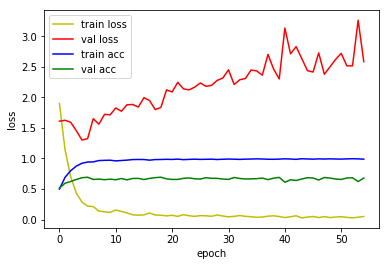

4815/4815 [==============================] - 17s 4ms/sample - loss: 1.4464 - acc: 0.6505
Loss: 1.446361458140618 Accuracy: 0.6504673

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5798 - acc: 0.5279
Epoch 00001: val_loss improved from inf to 1.46440, saving model to model/checkpoint/1D_CNN_custom_4_BN_5_conv_checkpoint/001-1.4644.hdf5
36805/36805 [==============================] - 420s 11ms/sample - loss: 1.5797 - acc: 0.5279 - val_loss: 1.4644 - val_acc: 0.5399
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0395 - acc: 0.6967
Epoch 00002: val_loss improved from 1.46440 to 1.08663, saving model to model/checkpoint/1D_CNN_custom_4_BN_5_conv_checkpoint/002-1.0866.hdf5
36805/36805 [==============================] - 415s 11ms/sample - loss: 1.0395 - acc: 0.6967 - val_loss: 1.0866 - val_acc: 0.6783
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8213 - a

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0500 - acc: 0.9883
Epoch 00029: val_loss did not improve from 0.87272
36805/36805 [==============================] - 415s 11ms/sample - loss: 0.0501 - acc: 0.9882 - val_loss: 1.2456 - val_acc: 0.7608
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0521 - acc: 0.9872
Epoch 00030: val_loss did not improve from 0.87272
36805/36805 [==============================] - 415s 11ms/sample - loss: 0.0524 - acc: 0.9871 - val_loss: 1.0883 - val_acc: 0.7845
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9933
Epoch 00031: val_loss did not improve from 0.87272
36805/36805 [==============================] - 415s 11ms/sample - loss: 0.0341 - acc: 0.9933 - val_loss: 0.9961 - val_acc: 0.7983
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9911
Epoch 00032: val_loss did not improve from 0.87272
36805/36805 [=====

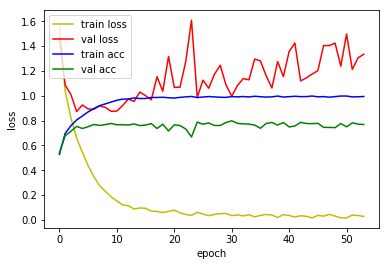

4815/4815 [==============================] - 17s 4ms/sample - loss: 1.0379 - acc: 0.7065
Loss: 1.037937605096296 Accuracy: 0.7065421

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5739 - acc: 0.5215
Epoch 00001: val_loss improved from inf to 1.40725, saving model to model/checkpoint/1D_CNN_custom_4_BN_6_conv_checkpoint/001-1.4072.hdf5
36805/36805 [==============================] - 425s 12ms/sample - loss: 1.5738 - acc: 0.5216 - val_loss: 1.4072 - val_acc: 0.5551
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9621 - acc: 0.7137
Epoch 00002: val_loss improved from 1.40725 to 0.89239, saving model to model/checkpoint/1D_CNN_custom_4_BN_6_conv_checkpoint/002-0.8924.hdf5
36805/36805 [==============================] - 417s 11ms/sample - loss: 0.9621 - acc: 0.7137 - val_loss: 0.8924 - val_acc: 0.7342
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7763 - a

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0586 - acc: 0.9871
Epoch 00027: val_loss did not improve from 0.48415
36805/36805 [==============================] - 417s 11ms/sample - loss: 0.0587 - acc: 0.9871 - val_loss: 0.5244 - val_acc: 0.8728
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0541 - acc: 0.9887
Epoch 00028: val_loss did not improve from 0.48415
36805/36805 [==============================] - 416s 11ms/sample - loss: 0.0544 - acc: 0.9887 - val_loss: 0.4918 - val_acc: 0.8807
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0695 - acc: 0.9833
Epoch 00029: val_loss did not improve from 0.48415
36805/36805 [==============================] - 416s 11ms/sample - loss: 0.0695 - acc: 0.9833 - val_loss: 0.5214 - val_acc: 0.8737
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0333 - acc: 0.9943
Epoch 00030: val_loss did not improve from 0.48415
36805/36805 [=====

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0226 - acc: 0.9956
Epoch 00057: val_loss did not improve from 0.48415
36805/36805 [==============================] - 417s 11ms/sample - loss: 0.0227 - acc: 0.9956 - val_loss: 0.5992 - val_acc: 0.8791
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9920
Epoch 00058: val_loss did not improve from 0.48415
36805/36805 [==============================] - 416s 11ms/sample - loss: 0.0320 - acc: 0.9920 - val_loss: 0.5251 - val_acc: 0.8919
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0142 - acc: 0.9979
Epoch 00059: val_loss did not improve from 0.48415
36805/36805 [==============================] - 416s 11ms/sample - loss: 0.0142 - acc: 0.9979 - val_loss: 0.6724 - val_acc: 0.8698
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0168 - acc: 0.9973
Epoch 00060: val_loss did not improve from 0.48415
36805/36805 [=====

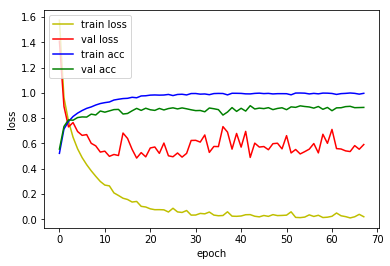

4815/4815 [==============================] - 17s 4ms/sample - loss: 0.5679 - acc: 0.8467
Loss: 0.5678957583872081 Accuracy: 0.846729

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7549 - acc: 0.4621
Epoch 00001: val_loss improved from inf to 1.44729, saving model to model/checkpoint/1D_CNN_custom_4_BN_7_conv_checkpoint/001-1.4473.hdf5
36805/36805 [==============================] - 429s 12ms/sample - loss: 1.7548 - acc: 0.4622 - val_loss: 1.4473 - val_acc: 0.5588
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0092 - acc: 0.7050
Epoch 00002: val_loss improved from 1.44729 to 1.05186, saving model to model/checkpoint/1D_CNN_custom_4_BN_7_conv_checkpoint/002-1.0519.hdf5
36805/36805 [==============================] - 418s 11ms/sample - loss: 1.0093 - acc: 0.7049 - val_loss: 1.0519 - val_acc: 0.7065
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7689 - a

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0628 - acc: 0.9852
Epoch 00026: val_loss did not improve from 0.26800
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0631 - acc: 0.9851 - val_loss: 0.3804 - val_acc: 0.9022
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0891 - acc: 0.9764
Epoch 00027: val_loss did not improve from 0.26800
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0892 - acc: 0.9764 - val_loss: 0.3096 - val_acc: 0.9192
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0698 - acc: 0.9827
Epoch 00028: val_loss improved from 0.26800 to 0.25185, saving model to model/checkpoint/1D_CNN_custom_4_BN_7_conv_checkpoint/028-0.2518.hdf5
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0698 - acc: 0.9827 - val_loss: 0.2518 - val_acc: 0.9285
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0195 - acc: 0.9959
Epoch 00055: val_loss did not improve from 0.24231
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0195 - acc: 0.9959 - val_loss: 0.2559 - val_acc: 0.9376
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9992
Epoch 00056: val_loss did not improve from 0.24231
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0097 - acc: 0.9992 - val_loss: 0.2585 - val_acc: 0.9378
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0161 - acc: 0.9969
Epoch 00057: val_loss did not improve from 0.24231
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0161 - acc: 0.9969 - val_loss: 0.3283 - val_acc: 0.9271
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9952
Epoch 00058: val_loss did not improve from 0.24231
36805/36805 [=====

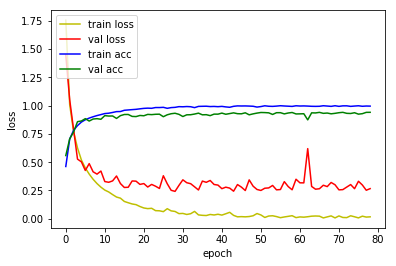

4815/4815 [==============================] - 17s 4ms/sample - loss: 0.3207 - acc: 0.9047
Loss: 0.3206527758919685 Accuracy: 0.9046729

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7211 - acc: 0.4814
Epoch 00001: val_loss improved from inf to 1.51776, saving model to model/checkpoint/1D_CNN_custom_4_BN_8_conv_checkpoint/001-1.5178.hdf5
36805/36805 [==============================] - 434s 12ms/sample - loss: 1.7211 - acc: 0.4814 - val_loss: 1.5178 - val_acc: 0.5332
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8988 - acc: 0.7449
Epoch 00002: val_loss improved from 1.51776 to 0.88499, saving model to model/checkpoint/1D_CNN_custom_4_BN_8_conv_checkpoint/002-0.8850.hdf5
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.8988 - acc: 0.7449 - val_loss: 0.8850 - val_acc: 0.7533
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6218 - 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9891
Epoch 00026: val_loss did not improve from 0.17978
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0464 - acc: 0.9891 - val_loss: 0.2135 - val_acc: 0.9446
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0529 - acc: 0.9865
Epoch 00027: val_loss did not improve from 0.17978
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0530 - acc: 0.9865 - val_loss: 0.1923 - val_acc: 0.9478
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0512 - acc: 0.9870
Epoch 00028: val_loss did not improve from 0.17978
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0513 - acc: 0.9869 - val_loss: 0.1884 - val_acc: 0.9464
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0435 - acc: 0.9897
Epoch 00029: val_loss did not improve from 0.17978
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9938
Epoch 00055: val_loss did not improve from 0.17421
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0232 - acc: 0.9938 - val_loss: 0.2411 - val_acc: 0.9415
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0057 - acc: 0.9993
Epoch 00056: val_loss did not improve from 0.17421
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0057 - acc: 0.9993 - val_loss: 0.1854 - val_acc: 0.9562
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0080 - acc: 0.9986
Epoch 00057: val_loss did not improve from 0.17421
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0080 - acc: 0.9986 - val_loss: 0.2572 - val_acc: 0.9392
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9980
Epoch 00058: val_loss did not improve from 0.17421
36805/36805 [==================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.9993
Epoch 00085: val_loss did not improve from 0.17155
36805/36805 [==============================] - 417s 11ms/sample - loss: 0.0050 - acc: 0.9993 - val_loss: 0.1946 - val_acc: 0.9574
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9919
Epoch 00086: val_loss did not improve from 0.17155
36805/36805 [==============================] - 417s 11ms/sample - loss: 0.0264 - acc: 0.9919 - val_loss: 0.2079 - val_acc: 0.9534
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0050 - acc: 0.9993
Epoch 00087: val_loss did not improve from 0.17155
36805/36805 [==============================] - 417s 11ms/sample - loss: 0.0050 - acc: 0.9993 - val_loss: 0.1866 - val_acc: 0.9571
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0031 - acc: 0.9995
Epoch 00088: val_loss did not improve from 0.17155
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0022 - acc: 0.9996
Epoch 00114: val_loss did not improve from 0.16986
36805/36805 [==============================] - 417s 11ms/sample - loss: 0.0022 - acc: 0.9996 - val_loss: 0.1867 - val_acc: 0.9613
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.9998
Epoch 00115: val_loss did not improve from 0.16986
36805/36805 [==============================] - 417s 11ms/sample - loss: 0.0021 - acc: 0.9998 - val_loss: 0.2015 - val_acc: 0.9569
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 0.9995
Epoch 00116: val_loss did not improve from 0.16986
36805/36805 [==============================] - 417s 11ms/sample - loss: 0.0030 - acc: 0.9995 - val_loss: 0.2489 - val_acc: 0.9467
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9986
Epoch 00117: val_loss did not improve from 0.16986
36805/36805 [===============

Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0017 - acc: 0.9998
Epoch 00144: val_loss did not improve from 0.16986
36805/36805 [==============================] - 416s 11ms/sample - loss: 0.0018 - acc: 0.9998 - val_loss: 0.1968 - val_acc: 0.9560
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0051 - acc: 0.9987
Epoch 00145: val_loss did not improve from 0.16986
36805/36805 [==============================] - 416s 11ms/sample - loss: 0.0053 - acc: 0.9986 - val_loss: 0.1958 - val_acc: 0.9548
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0119 - acc: 0.9966
Epoch 00146: val_loss did not improve from 0.16986
36805/36805 [==============================] - 417s 11ms/sample - loss: 0.0120 - acc: 0.9966 - val_loss: 0.1868 - val_acc: 0.9583
Epoch 147/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0074 - acc: 0.9980
Epoch 00147: val_loss did not improve from 0.16986
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.0016 - acc: 0.9998
Epoch 00173: val_loss did not improve from 0.16796
36805/36805 [==============================] - 417s 11ms/sample - loss: 0.0016 - acc: 0.9998 - val_loss: 0.2002 - val_acc: 0.9620
Epoch 174/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0018 - acc: 0.9998
Epoch 00174: val_loss did not improve from 0.16796
36805/36805 [==============================] - 417s 11ms/sample - loss: 0.0020 - acc: 0.9997 - val_loss: 0.2189 - val_acc: 0.9574
Epoch 175/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9958
Epoch 00175: val_loss did not improve from 0.16796
36805/36805 [==============================] - 417s 11ms/sample - loss: 0.0145 - acc: 0.9958 - val_loss: 0.1874 - val_acc: 0.9609
Epoch 176/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0017 - acc: 0.9998
Epoch 00176: val_loss did not improve from 0.16796
36805/36805 [===============

Epoch 203/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0013 - acc: 0.9998
Epoch 00203: val_loss did not improve from 0.16796
36805/36805 [==============================] - 416s 11ms/sample - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1911 - val_acc: 0.9620

1D_CNN_custom_4_BN_8_conv Model


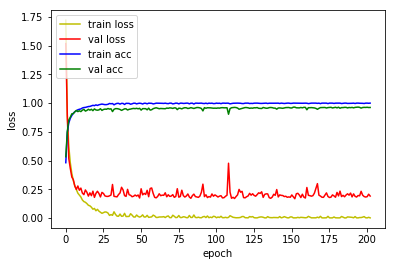

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.2162 - acc: 0.9522
Loss: 0.21618979500949012 Accuracy: 0.9522326

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4219 - acc: 0.5647
Epoch 00001: val_loss improved from inf to 1.25034, saving model to model/checkpoint/1D_CNN_custom_4_BN_9_conv_checkpoint/001-1.2503.hdf5
36805/36805 [==============================] - 440s 12ms/sample - loss: 1.4218 - acc: 0.5647 - val_loss: 1.2503 - val_acc: 0.6150
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6380 - acc: 0.8170
Epoch 00002: val_loss improved from 1.25034 to 0.50821, saving model to model/checkpoint/1D_CNN_custom_4_BN_9_conv_checkpoint/002-0.5082.hdf5
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.6379 - acc: 0.8170 - val_loss: 0.5082 - val_acc: 0.8656
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4419 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9934
Epoch 00026: val_loss did not improve from 0.15492
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0307 - acc: 0.9934 - val_loss: 0.1588 - val_acc: 0.9578
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9948
Epoch 00027: val_loss did not improve from 0.15492
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0256 - acc: 0.9948 - val_loss: 0.1804 - val_acc: 0.9506
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9934
Epoch 00028: val_loss did not improve from 0.15492
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0296 - acc: 0.9934 - val_loss: 0.1589 - val_acc: 0.9532
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9960
Epoch 00029: val_loss did not improve from 0.15492
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.9993
Epoch 00055: val_loss did not improve from 0.14978
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0048 - acc: 0.9993 - val_loss: 0.1595 - val_acc: 0.9599
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9985
Epoch 00056: val_loss did not improve from 0.14978
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0075 - acc: 0.9985 - val_loss: 0.1794 - val_acc: 0.9571
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0211 - acc: 0.9938
Epoch 00057: val_loss did not improve from 0.14978
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0211 - acc: 0.9938 - val_loss: 0.1887 - val_acc: 0.9560
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0074 - acc: 0.9986
Epoch 00058: val_loss did not improve from 0.14978
36805/36805 [==================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0035 - acc: 0.9992
Epoch 00085: val_loss did not improve from 0.14978
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0035 - acc: 0.9992 - val_loss: 0.2034 - val_acc: 0.9515
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0063 - acc: 0.9985
Epoch 00086: val_loss did not improve from 0.14978
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0063 - acc: 0.9985 - val_loss: 0.1873 - val_acc: 0.9606
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0094 - acc: 0.9972
Epoch 00087: val_loss did not improve from 0.14978
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0094 - acc: 0.9972 - val_loss: 0.1683 - val_acc: 0.9632
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9994
Epoch 00088: val_loss did not improve from 0.14978
36805/36805 [=====

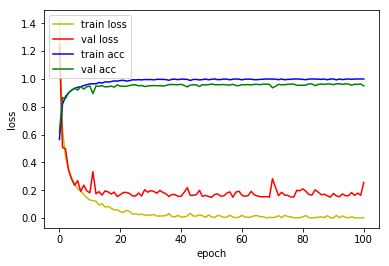

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.2029 - acc: 0.9431
Loss: 0.20290481865344143 Accuracy: 0.9430945



In [11]:
for i in range(4, 10):
    base = '1D_CNN_custom_4_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [12]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_4_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 2

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.5679 - acc: 0.8467
Loss: 0.5678957583872081 Accuracy: 0.846729

1D_CNN_custom_4_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_61 (Activation)   (None, 16000,

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.2162 - acc: 0.9522
Loss: 0.21618979500949012 Accuracy: 0.9522326

1D_CNN_custom_4_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_76 (Activation)   (None, 1600

In [13]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 2

4815/4815 [==============================] - 19s 4ms/sample - loss: 0.6993 - acc: 0.8577
Loss: 0.6992539117393216 Accuracy: 0.85773623

1D_CNN_custom_4_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_61 (Activation)   (None, 1600

4815/4815 [==============================] - 20s 4ms/sample - loss: 0.2494 - acc: 0.9514
Loss: 0.2493953763675583 Accuracy: 0.9514019

1D_CNN_custom_4_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_76 (Activation)   (None, 16000